# 다양한 데이터 분류기 만들기
<br />

### 목표
`scikit-learn`에서 제공하는 toy database 중 서로 다른 세가지(load_digits, load_wine, load_breast_cancer) 데이터 셋과 다양한 모델*(Decision Tree, Random Forest, SVM, SGD Classifier, Logistic Regression)*을 활용하여 다양한 분류기를 만들어 본다.

## 0. 모델 학습과 평가 함수 정의
본 프로젝트에서는 다양한 데이터를 동일한 모델들을 사용하여 학습을 하고 평가를 하는 공통적인 과정이 반복적으로 등장한다. 이를 위하여 5개의 분류 모델을 학습하여 반환하는 함수와 모델들을 평가하여 결과를 출력하는 함수 두 가지를 사전에 작성하고자 한다.

In [7]:
# import package
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import pandas as pd

import pprint
import numpy as np
import matplotlib.pyplot as plt

RANDOM_STATE = 54

* `get_trained_models` : train 데이터를 입력받아, 학습된 서로 다른 5개의 모델을 반환한다.

In [24]:
def get_trained_models(random_state, X_train, y_train):
    models = {}
    
    # Decision Tree
    decision_tree_model = DecisionTreeClassifier(random_state=random_state)
    decision_tree_model.fit(X_train, y_train)
    print("Training [Decision Tree] completed !")
    models['DecisionTree'] = decision_tree_model
    
    # Random Forest
    random_forest_model = RandomForestClassifier(random_state=random_state)
    random_forest_model.fit(X_train, y_train)
    print("Training [Random Forest] completed !")
    models['RandomForest'] = random_forest_model
    
    # SVM
    svm_model = svm.SVC()
    svm_model.fit(X_train, y_train)
    print("Training [SVC] completed !")
    models['SVC'] = svm_model
    
    # SGD Classifier
    sgd_model = SGDClassifier()
    sgd_model.fit(X_train, y_train)
    print("Training [SGD] completed !")
    models['SGD'] = sgd_model
    
    # Logistic Regression
    logistic_model = LogisticRegression(solver='lbfgs', max_iter=2000)
    logistic_model.fit(X_train, y_train)
    print("Training [Logistic Regression] completed !")
    models['LogisticRegression'] = logistic_model
    
    return models

* `get_models_evaluation` : test 데이터와 학습된 모델을 입력받아 모델에 대한 평가지표(pandas.DataFrame)을 반환한다.

In [1]:
def get_models_evaluation(models, X_test, y_test):
    evaluations = {}
    df_indexs = ['precision score(macro avg)', 'precision score(weighted avg)',
                 'recall score(macro avg)', 'recall score(weighted avg)',
                 'f1 score(macro avg)', 'f1 score(weighted avg)']
    for model_name in models.keys():
        y_pred = models[model_name].predict(X_test)
        evaluations[model_name] = [
            precision_score(y_test, y_pred, average='macro'),
            precision_score(y_test, y_pred, average='weighted'),
            recall_score(y_test, y_pred, average='macro'),
            recall_score(y_test, y_pred, average='weighted'),
            f1_score(y_test, y_pred, average='macro'),
            f1_score(y_test, y_pred, average='weighted')
        ]
#     print(classification_report(y_test, y_pred))
    evaluation_df = pd.DataFrame(evaluations, index=df_indexs)
    
    return evaluation_df

## 1. load_digits를 이용한 손글씨 분류

### (1) 필요한 모듈 import 하기

In [4]:
# 위에서 대부분의 package를 추가하였으므로 손글씨를 불러들여오는 load_digits만 추가하였다
from sklearn.datasets import load_digits

### (2) 데이터 준비
`load_digits` 메서드를 활용하여 데이터를 불러온다.

In [5]:
digits = load_digits()
dir(digits)

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']

label : 0(0)
array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])


<Figure size 432x288 with 0 Axes>

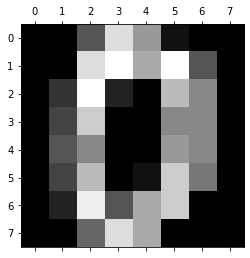

In [8]:
# 데이터가 잘 불러와 졌는지 확인
print("label : {}({})".format(digits.target[0], digits.target_names[digits.target[0]]))

pprint.pprint(digits.data[0].reshape(8,8))

plt.gray()
plt.matshow(digits.images[0])
plt.show()

출력된 배열과 이미지의 모양이 label과 같은 0임을 확인하여 데이터가 잘 불러와졌음을 확인 할 수 있었다.

### (3) 데이터 이해하기
데이터 문서에 따르면 `load_digits`으로 불러들인 데이터의 각 멤버 변수를 다음과 같은 의미를 가진다.
* data : 8x8 이미지 데이터를 평탄화한 배열의 집합으로, 총 1797개의 손글씨 이미지 데이터이다. 모델에 사용되는 **feature data**가 된다.
* feature_names : 데이터의 column 명으로 픽셀의 인덱스를 의미하고 있다.
* images : raw 이미지 데이터이다. 이를 편탄화 시킨것이 data이다.
* target : data에 대응되는 값으로 해당 손글씨가 어떤 숫자인지를 저장하고 있다. 모델에 사용되는 **label data**가 된다.
* target_names : target이 의미하는 실제 값으로 이 데이터에서는 인덱스와 같은 숫자 값이 된다.


In [9]:
digits_data = digits.data
digits_label = digits.target

In [10]:
digits.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

### (4) train, test 데이터 분리

In [25]:
digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(
    digits_data, 
    digits_label, 
    test_size=0.2, 
    random_state=7)

### (5) 다양한 모델로 학습시켜보기

In [26]:
models = get_trained_models(39, digits_X_train, digits_y_train)

Training [Decision Tree] completed !
Training [Random Forest] completed !
Training [SVC] completed !
Training [SGD] completed !
Training [Logistic Regression] completed !


###  (6) 모델을 평가해 보기

In [23]:
get_models_evaluation(models, digits_X_test, digits_y_test)

,DecisionTree,RandomForest,SVC,SGD,LogisticRegression
precision score(macro avg),0.856277,0.961940,0.988788,0.940067,0.952326
precision score(weighted avg),0.853476,0.963030,0.989512,0.938502,0.955294
recall score(macro avg),0.855737,0.963093,0.989898,0.933723,0.953345
recall score(weighted avg),0.850000,0.961111,0.988889,0.930556,0.952778
f1 score(macro avg),0.853488,0.960931,0.989024,0.933083,0.951512
f1 score(weighted avg),0.849173,0.960416,0.988877,0.930045,0.952886


In [79]:
위의 평가표를 기반으로 하였을 때, 가장 값이 좋은 모델은 SVC이다. 

### ref
* [pprint : 쉽고 예쁘게 출력하기](https://pythonkim.tistory.com/91)
* [마이크로 평균(Micro-average), 매크로 평균(Macro-average) 이란 무엇인가?](https://unlimitedpower.tistory.com/entry/IR-마이크로-평균Micro-average-매크로-평균Macro-average-이란-무엇인가)
* [분류 성능평가](https://datascienceschool.net/03%20machine%20learning/09.04%20%EB%B6%84%EB%A5%98%20%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80.html)
* [pandas.Dataframe – 1편 객체 생성 및 row 추가방법](https://ldgeao99.tistory.com/6?category=820980)